# Tutorial IX - Safety Planning for the Islamic Pilgrimage in Mecca

Applied Optimization with Julia

# Introduction

The Hajj, one of the world’s largest religious gatherings, presents
fascinating and very important optimization challenges. During this
annual pilgrimage to Mecca, millions of Muslims perform sacred rituals,
including the symbolic stoning of the devil. Your task is to create an
efficient scheduling system that ensures both safety and spiritual
fulfillment for all pilgrims.

## The challenge

You’re responsible for scheduling 15 pilgrim groups
$\mathcal{S} \in \{g1,g2,...,g15\}$ across 6 time periods
$\mathcal{T} \in \{t1,t2,...,t6\}$ for the Jamarat ritual.

The groups $\mathcal{S}$ reside in two different camps
$\mathcal{C} \in \{A,B\}$. The first 6 groups are in camp A while the
other groups are in camp B. Each camp has only one path
$\mathcal{P} \in \{A-S-A,B-S-B\}$ and both paths have only one resource
$\mathcal{R}$, the stoning of the devil.

The capacity of the stoning is 10,000 pilgrims per period and there is
no period offset between the stoning and the capacity utilization. Each
group can stone the devil in any period $t$.

To constrain the fluctuation of the resource utilization $\sigma$ was
set to 0.3 while the first period is not constrained. Consider that the
number of pilgrims per group $s$ and the penalty value $f_{s,t}$ are
given.

------------------------------------------------------------------------

# 1. Problem Identification

You’ll need to create an optimization model that:

1.  Keeps everyone safe by respecting capacity limits
2.  Maintains steady flow between periods
3.  Maximizes pilgrim satisfaction by considering their time preferences

The model can be simplified when compared to the full model from the
lecture in several ways!

Please illustrate possible simplifications in a few sentences in the
cell below and document the key sets, parameters, and decision variables
needed and which elements we can eliminate and why.

> **Tip**
>
> To solve this task, it can be helpful to work with paper and pen to
> sketch the problem, and get a better understanding.

In [1]:
#=
Compared to the model that we've seen in the lecture, the problem definition in this notebook has significantly been simplified. There is only one
ritual, one path per camp, and a single shared resource. All groups can access all time periods, so time availability constraint can be omitted.
The model only wants us to assign each pilgrim group to exactly one time period with respect to capacity and fluctuation.

The key sets are pilgrim groups and time periods, the main parameters are group sizes, penalties, capacity, and fluctuation limit. There are only two
decision variables, and those are group-to-period assignment and period loads.
=#

------------------------------------------------------------------------

# 2. Implementing the Model

Now, implement and solve the problem defined in the previous task. This
time, a draft is not available and you have to implement everything
yourself. Note, that the number of pilgrims per group $s$ and the
penalty value $f_{s,t}$ are provided as CSV files.

## Load the Data

Start by loading the data into the notebook for the number of pilgrims
per group and the penalty value per group per period.

In [3]:
# YOUR CODE BELOW
using DelimitedFiles
using CSV
using DataFrames
using JuMP
using HiGHS
using Plots

file_directory = "$(@__DIR__)/data"

pilgrim = CSV.read("$file_directory/pilgrims.csv", DataFrame)
penalty = CSV.read("$file_directory/penalty.csv", DataFrame)

Row,Column1,t1,t2,t3,t4,t5,t6
,String3,Float64,Float64,Float64,Float64,Float64,Float64
1,g1,1.42716,0.42716,0.57284,1.57284,2.57284,3.57284
2,g2,2.93683,1.93683,0.936832,0.0631676,1.06317,2.06317
3,g3,2.14881,1.14881,0.148806,0.851194,1.85119,2.85119
4,g4,0.11706,0.88294,1.88294,2.88294,3.88294,4.88294
5,g5,2.2611,1.2611,0.261102,0.738898,1.7389,2.7389
6,g6,4.49389,3.49389,2.49389,1.49389,0.493887,0.506113
7,g7,4.15715,3.15715,2.15715,1.15715,0.15715,0.84285
8,g8,1.27074,0.27074,0.72926,1.72926,2.72926,3.72926
9,g9,3.1555,2.1555,1.1555,0.155498,0.844502,1.8445


## Define all Sets, Parameters and Variables

Please define all sets, parameters and variables you are going to use in
the following cell. Make sure to read the task above carefully, as the
problem can be modelled much simpler than the full model from the
lecture, due to certain properties of the problem.

In [4]:
# YOUR CODE BELOW

# Sets - The sets fot this problem is the groups (g1, g2, ..., g15) and time periods (t1, t2, ..., t6)
S = pilgrim[:, 1]
T = names(penalty)[2: end]

# Parameters
s = Dict(pilgrim.Column1 .=> pilgrim.pilgrims)
f = Dict((penalty[i, 1], t) => penalty[i, t] for i in 1:nrow(penalty), t in T)
capacity = 10000
delta = 0.3

# The model definition
model = Model(HiGHS.Optimizer)

# Decision Variables
@variable(model, X[S, T], Bin)
@variable(model, L[T] >= 0)

1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, ["t1", "t2", "t3", "t4", "t5", "t6"]
And data, a 6-element Vector{VariableRef}:
 L[t1]
 L[t2]
 L[t3]
 L[t4]
 L[t5]
 L[t6]

## Define the Model

Define the objective function and all constraints of the model in the
following cell.

In [5]:
# YOUR CODE BELOW

# Constraint 1 - Each group assigned exactly one
@constraint(
    model,
    [i in S],
    sum(X[i, t] for t in T) == 1
)

# Constraint 2 - Capacity constraint per period
@constraint(
    model,
    [t in T],
    sum(s[i] * X[i, t] for i in S) <= capacity
)

# Constraint 3 - Load definition
@constraint(
    model,
    [t in T],
    L[t] == sum(s[i] * X[i, t] for i in S)
)

# Constraint 4 - Fluctuation constraints (It says above that no fluctuation for the first period)
@constraint(model, [i in 2:length(T)],
    L[T[i]] - L[T[i - 1]] <= delta * L[T[i - 1]]
)

@constraint(model, [i in 2:length(T)],
    L[T[i - 1]] - L[T[i]] <= delta * L[T[i - 1]]
)

# The objective function
@objective(model, Min,
    sum(f[(i, t)] * X[i, t] for i in S, t in T)
)

1.4271597967286924 X[g1,t1] + 0.4271597967286924 X[g1,t2] + 0.5728402032713076 X[g1,t3] + 1.5728402032713076 X[g1,t4] + 2.5728402032713076 X[g1,t5] + 3.5728402032713076 X[g1,t6] + 2.936832418946552 X[g2,t1] + 1.936832418946552 X[g2,t2] + 0.936832418946552 X[g2,t3] + 0.063167581053448 X[g2,t4] + 1.063167581053448 X[g2,t5] + 2.063167581053448 X[g2,t6] + 2.148806013743438 X[g3,t1] + 1.148806013743438 X[g3,t2] + 0.14880601374343794 X[g3,t3] + 0.8511939862565621 X[g3,t4] + 1.851193986256562 X[g3,t5] + 2.851193986256562 X[g3,t6] + 0.1170600255738461 X[g4,t1] + 0.8829399744261539 X[g4,t2] + 1.882939974426154 X[g4,t3] + 2.882939974426154 X[g4,t4] + 3.882939974426154 X[g4,t5] + 4.882939974426154 X[g4,t6] + 2.261101565529233 X[g5,t1] + 1.2611015655292328 X[g5,t2] + 0.2611015655292328 X[g5,t3] + 0.7388984344707672 X[g5,t4] + 1.7388984344707672 X[g5,t5] + 2.738898434470767 X[g5,t6] + [[...30 terms omitted...]] + 4.396816263992751 X[g11,t1] + 3.3968162639927506 X[g11,t2] + 2.3968162639927506 X[g11,

## Solve the Model

Solve the model and print the results. What is the total dissatisfaction
with the resulting timetable?

In [6]:
# YOUR CODE BELOW
optimize!(model)

Running HiGHS 1.12.0 (git hash: 755a8e027): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 37 rows; 96 cols; 296 nonzeros; 90 integer variables (90 binary)
Coefficient ranges:
  Matrix  [7e-01, 6e+03]
  Cost    [3e-02, 5e+00]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 1e+04]
Presolving model
37 rows, 96 cols, 296 nonzeros  0s
31 rows, 96 cols, 206 nonzeros  0s
Presolve reductions: rows 31(-6); columns 96(-0); nonzeros 206(-90) 

Solving MIP model with:
   31 rows
   96 cols (90 binary, 0 integer, 6 implied int., 0 continuous, 0 domain fixed)
   206 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial zero

        Nodes      |    B&B Tree     |         

> **Tip**
>
> If you end up with an objective value of approximately 7, you have
> likely found the optimal solution to the problem.

------------------------------------------------------------------------

## Analyze the Results

Plot the utilization of the resource by using the `Plots` package.

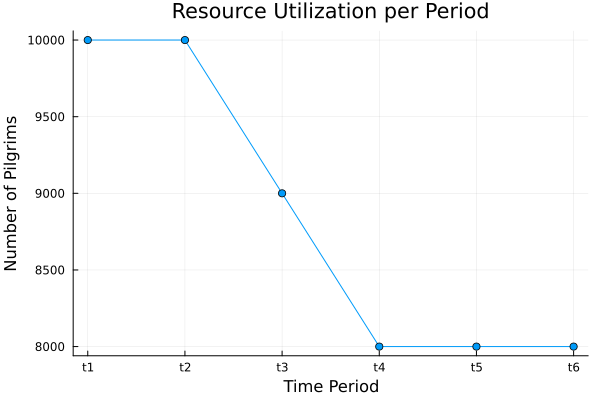

In [10]:
# YOUR CODE BELOW
periods = collect(T)
utilization = [value(L[t]) for t in periods]

plot(
    periods,
    utilization,
    xlabel = "Time Period",
    ylabel = "Number of Pilgrims",
    title  = "Resource Utilization per Period",
    marker = :circle,
    legend = false
)

Finally, reflect in a few sentences on the simplifications you made to
the model and how they affected the solution.

In [ ]:
#=
As we can see in the graph, the capacity constraint is binding in the first two time periods. This is related to high demands for early times slot
due to lower penalties. The gradual decrease reflects the effect of the fluctuation constraint.
=#

------------------------------------------------------------------------

# Solutions

You will likely find solutions to most exercises online. However, I
strongly encourage you to work on these exercises independently without
searching explicitly for the exact answers to the exercises.
Understanding someone else’s solution is very different from developing
your own. Use the lecture notes and try to solve the exercises on your
own. This approach will significantly enhance your learning and
problem-solving skills.

Remember, the goal is not just to complete the exercises, but to
understand the concepts and improve your programming abilities. If you
encounter difficulties, review the lecture materials, experiment with
different approaches, and don’t hesitate to ask for clarification during
class discussions.